# EXP: Word Embeddings Example - PyTorch

__Word Embeddings: Encoding Lexical Semantics__

Word embeddings are dense vectors of real numbers, one per word in your vocabulary. In NLP, it is almost always the case that your features are words! But how should you represent a word in a computer? You could store its ASCII character representation, but that only tells you what the word is, it doesn’t say much about what it means (you might be able to derive its part of speech from its affixes, or properties from its capitalization, but not much). Even more, in what sense could you combine these representations? We often want dense outputs from our neural networks, where the inputs are ∣V∣|V|∣V∣ dimensional, where VVV is our vocabulary, but often the outputs are only a few dimensional (if we are only predicting a handful of labels, for instance). How do we get from a massive dimensional space to a smaller dimensional space?

How about instead of ASCII representations, we use a one-hot encoding? There is an enormous drawback to this representation, besides just how huge it is. _It basically treats all words as independent entities with no relation to each other_. __What we really want is some notion of _similarity_ between words__.

- What we mean by a notion of similarity is: __we mean _semantic similarity_, not simply having similar orthographic representations__.
- It is a technique to combat the sparsity of linguistic data, by connecting the dots between what we have seen and what we haven’t.

This example of course relies on a fundamental linguistic assumption: that words appearing in similar contexts are related to each other semantically. This is called the [distributional hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics).


__Central to the idea of deep learning is that the neural network learns representations of the features, rather than requiring the programmer to design them herself__. So _why not just let the word embeddings be parameters in our model, and then be updated during training?_ This is exactly what we will do. _We will have some latent semantic attributes that the network can, in principle, learn_.

Note that the word embeddings will probably not be interpretable. That is, although with our hand-crafted vectors we can see that (say) mathematicians and physicists are similar in that they both like coffee, if we allow a neural network to learn the embeddings and see that both mathematicians and physicists have a large value in the second dimension, it is not clear what that means. They are similar in some latent semantic dimension, but this probably has no interpretation to us.

In summary, __word embeddings are a representation of the _semantics_ of a word, efficiently encoding semantic information that might be relevant to the task at hand__. You can embed other things too: part of speech tags, parse trees, anything! The idea of feature embeddings is central to the field.

- [Reference](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)
- [example](https://www.educba.com/pytorch-embedding/)

### Word Embeddings in Pytorch

Before we get to a worked example and an exercise, a few quick notes about how to use embeddings in Pytorch and in deep learning programming in general. Similar to how we defined a unique index for each word when making one-hot vectors, __we__ also __need to define an index for each word when using embeddings. These will be keys into a lookup table__. That is, __embeddings are stored as a $∣V∣ \times D$ matrix__, where $D$ is the dimensionality of the embeddings, such that the word assigned index $i$ has its embedding stored in the $i^{th}$ row of the matrix. In all of the code, the mapping from words to indices is a dictionary named ```word_to_ix```.

- The module that allows you to use embeddings is ```torch.nn.Embedding```, which takes two arguments: the vocabulary size, and the dimensionality of the embeddings.

- To index into this table, you must use ```torch.LongTensor``` (since the indices are integers, not floats).

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext

import numpy as np
import matplotlib.pyplot as plt
import pickle

C:\Users\arjun\anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.12.1


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Python3 dict for mapping from words to indices-
word_to_ix = {"hello": 0, "world": 1}

# Create an embedding matrix for 2 words in our vocabulary. Embedding dim = 5-
embeds = nn.Embedding(
    num_embeddings = 2, embedding_dim = 5
)

In [7]:
# Get (random) embeddings for words in the mapping dict-
for w in word_to_ix.keys():
    wrd_embed = embeds(torch.tensor(word_to_ix[w], dtype = torch.long))
    print(f"word: {w} has embedding:\n{wrd_embed}\n")

word: hello has embedding:
tensor([-0.5115, -1.1887,  0.4204,  0.5859, -0.1765],
       grad_fn=<EmbeddingBackward0>)

word: world has embedding:
tensor([-0.1238,  1.0840,  0.3871, -1.0026,  0.4309],
       grad_fn=<EmbeddingBackward0>)



### An Example: N-Gram Language Modeling

Recall that in an _n-gram_ language model, given a sequence of words $w$, we want to compute:

$P\left(w_i|w_{i-1}, w_{i-2}, ..., w_{i-n+1}\right)$

Where $w_i$ is the $i^{th}$ word of the sequence.

In this example, we will compute the loss function on some training examples and update the parameters with backpropagation.

In [8]:
# Define hyper-parameters-
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10

In [13]:
# Using Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold."""

In [14]:
# Tokenize text-
tokenizer = torchtext.data.get_tokenizer("basic_english")

In [15]:
tokens = tokenizer(test_sentence)

In [16]:
print(f"Number of tokens = {len(tokens)}")

Number of tokens = 144


In [20]:
# Build a list of tuples.
# Each tuple is ([word_i-CONTEXT_SIZE, ..., word_i-1], target word)
ngrams = [
    (
        [tokens[i - j - 1] for j in range(CONTEXT_SIZE)],
        tokens[i]
    )
    for i in range(CONTEXT_SIZE, len(tokens))
]

In [21]:
print(f"length of n-gram model = {len(ngrams)}")

length of n-gram model = 142


In [22]:
print(f"The first 5 n-gram model:\n{ngrams[:5]}")

The first 5 n-gram model:
[(['forty', 'when'], 'winters'), (['winters', 'forty'], 'shall'), (['shall', 'winters'], 'besiege'), (['besiege', 'shall'], 'thy'), (['thy', 'besiege'], 'brow')]


In [23]:
# Create vocabulary-
vocab = set(tokens)

# Python3 dict to map from words to their indices-
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [24]:
print(f"length of vocabulary = {len(vocab)}")

length of vocabulary = 92


In [25]:
print(f"5 dict kays are: {list(word_to_ix.keys())[:5]}")

5 dict kays are: ['forty', 'treasure', 'st', 'were', 'all-eating']


In [26]:
class NGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings = vocab_size, embedding_dim = embedding_dim
        )
        self.linear1 = nn.Linear(in_features = context_size * embedding_dim, out_features = 128)
        self.linear2 = nn.Linear(in_features = 128, out_features = vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim = 1)
        return log_probs
    

In [27]:
# Instantiate an instance of LM-
model = NGramLanguageModeler(
    vocab_size = len(vocab), embedding_dim = EMBEDDING_DIM,
    context_size = CONTEXT_SIZE
).to(device)

In [28]:
# Python3 dict to contain losses-
losses = {}

# Define negative log-likelihood loss-
loss_function = nn.NLLLoss()

In [29]:
# Use SGD optimizer-
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [30]:
# Train language model for these epochs-
num_epochs = 200

In [31]:
for epoch in range(num_epochs):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)-
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype = torch.long).to(device)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance-
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words-
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(
            log_probs,
            torch.tensor([word_to_ix[target]], dtype = torch.long).to(device)
        )

        # Step 5. Do the backward pass and update the gradient-
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()-
        total_loss += loss.item()
    
    print(f"epoch = {epoch + 1}, loss = {total_loss:.4f}")
    
    # Add loss-
    losses[epoch + 1] = total_loss
    

epoch = 1, loss = 648.8161
epoch = 2, loss = 644.1093
epoch = 3, loss = 639.4745
epoch = 4, loss = 634.9085
epoch = 5, loss = 630.4079
epoch = 6, loss = 625.9692
epoch = 7, loss = 621.5923
epoch = 8, loss = 617.2769
epoch = 9, loss = 613.0202
epoch = 10, loss = 608.8225
epoch = 11, loss = 604.6847
epoch = 12, loss = 600.6053
epoch = 13, loss = 596.5842
epoch = 14, loss = 592.6230
epoch = 15, loss = 588.7188
epoch = 16, loss = 584.8732
epoch = 17, loss = 581.0859
epoch = 18, loss = 577.3562
epoch = 19, loss = 573.6858
epoch = 20, loss = 570.0734
epoch = 21, loss = 566.5175
epoch = 22, loss = 563.0136
epoch = 23, loss = 559.5591
epoch = 24, loss = 556.1509
epoch = 25, loss = 552.7846
epoch = 26, loss = 549.4593
epoch = 27, loss = 546.1719
epoch = 28, loss = 542.9242
epoch = 29, loss = 539.7121
epoch = 30, loss = 536.5328
epoch = 31, loss = 533.3816
epoch = 32, loss = 530.2540
epoch = 33, loss = 527.1508
epoch = 34, loss = 524.0708
epoch = 35, loss = 521.0076
epoch = 36, loss = 517.9622
e

#### Sanity check

In [32]:
context, target

(['cold', 'it'], '.')

In [33]:
context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype = torch.long).to(device)

In [34]:
context_idxs

tensor([74, 90], device='cuda:0')

In [35]:
log_probs = model(context_idxs)

In [36]:
log_probs.shape, context_idxs.shape

(torch.Size([1, 92]), torch.Size([2]))

In [37]:
loss_function(
    log_probs,
    torch.tensor([word_to_ix[target]], dtype = torch.long).to(device)
).cpu().detach().numpy()

array(0.21412897, dtype=float32)

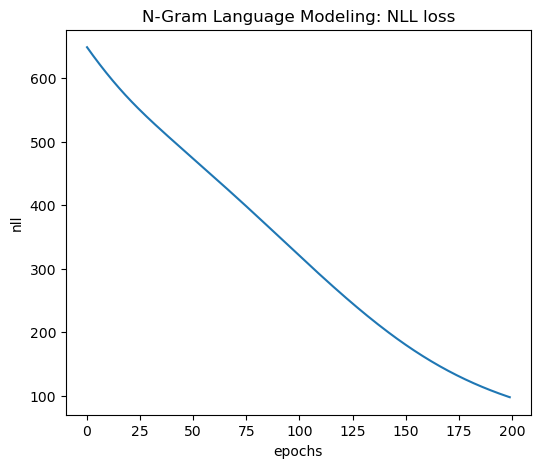

In [38]:
plt.figure(figsize = (6, 5))
plt.plot([losses[k] for k in losses.keys()])
plt.xlabel("epochs")
plt.ylabel("nll")
plt.title("N-Gram Language Modeling: NLL loss")
plt.show()

In [39]:
print(f"Dimensions of learned embedding matrix: {model.embeddings.weight.shape}")

Dimensions of learned embedding matrix: torch.Size([92, 10])


In [40]:
# Randomly choose a word from the text corpus-
random_wrd = np.random.choice(a = list(word_to_ix.keys()), size = 1, replace = False)[0]

In [41]:
# To get the embedding of a particular word, e.g. "beauty"
print(f"Learned embedding for the word: {random_wrd} is:\n{model.embeddings.weight[word_to_ix[random_wrd]].cpu().detach().numpy()}")

Learned embedding for the word: couldst is:
[-0.6795246  -0.23531438 -0.04182692 -1.2779577  -0.54892033  1.1771073
 -1.5215546  -0.6584726  -0.43037704  1.1042604 ]


In [42]:
word_to_ix[random_wrd]

84

In [43]:
model.embeddings.weight[84].cpu().detach().numpy()

array([-0.6795246 , -0.23531438, -0.04182692, -1.2779577 , -0.54892033,
        1.1771073 , -1.5215546 , -0.6584726 , -0.43037704,  1.1042604 ],
      dtype=float32)

### Computing Word Embeddings: _Continuous Bag-of-Words_

The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep learning.

- __It is a model that tries to predict words given the context of a few words before and a few words after the target word__.
- __This is distinct from language modeling, since CBOW is not sequential and does not have to be probabilistic__.
- _Typically, CBOW is used to quickly train word embeddings, and these embeddings are used to initialize the embeddings of some more complicated model_.
- Usually, this is referred to as _pretraining embeddings_. It almost always helps performance a couple of percent.

The CBOW model is as follows: __Given a target word $w_i$ and a $N$ context window on each side, $w_{i-1}$, ..., $w_{i-N}$ and $w_{i+1}$, ..., $w_{i+N}$ referring to all context words collectively as $C$, CBOW tries to minimize-__

$−logp\left(w_i∣C\right)=-logSoftmax\left(A\left(\sum_{w \in C} q_w\right) + b\right)$

where $q_w$ is the embedding for word $w$.

In [79]:
# 2 words to the left, 2 to the right-
CONTEXT_SIZE = 2

In [80]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

In [81]:
print(f"Length of input text = {len(raw_text)}")

Length of input text = 62


In [82]:
# By deriving a set from `raw_text`, we deduplicate the array-
vocab = set(raw_text)
vocab_size = len(vocab)
print(f"Size of vocabulary = {vocab_size}")

Size of vocabulary = 49


In [83]:
# Python3 dict to map from words to indices-
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [84]:
data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = (
        [raw_text[i - j - 1] for j in range(CONTEXT_SIZE)]
        + [raw_text[i + j + 1] for j in range(CONTEXT_SIZE)]
    )
    target = raw_text[i]
    data.append((context, target))

In [85]:
len(data)

58

In [87]:
c, t = data[2]
print(f"For the given context: {c}, predict target: {t}")

For the given context: ['to', 'about', 'the', 'idea'], predict target: study


In [ ]:
class CBOW(nn.Module):
    def __init__(self):
        pass

    def forward(self, inputs):
        pass

# Create your model and train. Here are some functions to help you make
# the data ready for use by your module.

In [88]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype = torch.long)


In [89]:
make_context_vector(data[0][0], word_to_ix)

tensor([42, 15, 26,  3])

In [91]:
data[0], data[0][0]

((['are', 'We', 'to', 'study'], 'about'), ['are', 'We', 'to', 'study'])